<a href="https://colab.research.google.com/github/makkimaki/siamese-network-coursera-tutorial/blob/main/Copy_of_Deep_Learning_with_PyTorch_Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 1.9 MB/s 
     |████████████████████████████████| 376 kB 59.8 MB/s 
     |████████████████████████████████| 58 kB 6.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=d2f46dbe072eeea08edfb524ae91c86ba8b5861fff3b55a21d1be4bdb4bc60e3
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=a9cedf6bffb9c43576fb2c35a315c5ea846bf8821c79610b57fd9d78a05ba3ad
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 11.24 MiB/s, done.


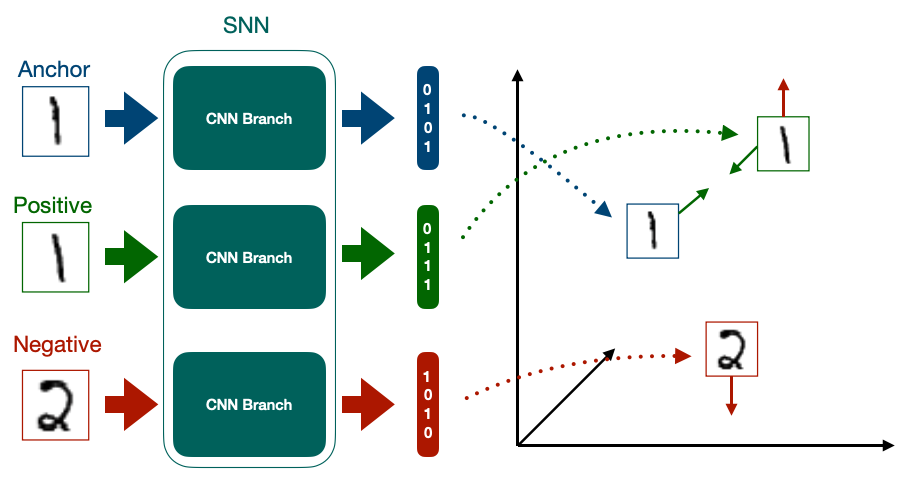

# Imports

In [ ]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [ ]:
DATA_DIR = "/content/Person-Re-Id-Dataset/train/"
CSV_FILE = "/content/Person-Re-Id-Dataset/train.csv"

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = "cuda"

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head() 

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


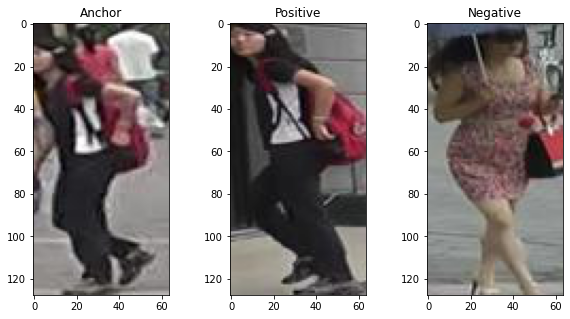

In [ ]:
row = df.iloc[4]

Anchor_img = io.imread(DATA_DIR + row.Anchor)
Positive_img = io.imread(DATA_DIR + row.Positive)
Negative_img = io.imread(DATA_DIR + row.Negative)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))

ax1.set_title("Anchor")
ax1.imshow(Anchor_img)

ax2.set_title("Positive")
ax2.imshow(Positive_img)

ax3.set_title("Negative")
ax3.imshow(Negative_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Create APN Dataset 

In [ ]:
class APN_Dataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        Anchor_img = io.imread(DATA_DIR + row.Anchor)
        Positive_img = io.imread(DATA_DIR + row.Positive)
        Negative_img = io.imread(DATA_DIR + row.Negative)

        A_img = torch.from_numpy(Anchor_img).permute(2, 0, 1) / 255.0
        P_img = torch.from_numpy(Positive_img).permute(2, 0, 1) / 255.0
        N_img = torch.from_numpy(Negative_img).permute(2, 0, 1) / 255.0

        return A_img, P_img, N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 3200
Size of validset: 800


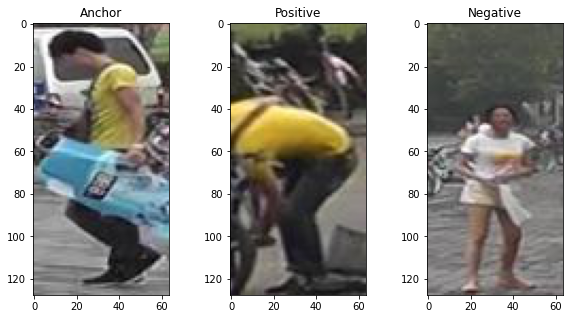

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(train_loader)}")
print(f"No. of batches in validloader : {len(valid_loader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A, P, N in train_loader:
    break;
    
print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model 

In [ ]:
class APN_Model(nn.Module):
    def __init__(self, emb_size=512):
        super(APN_Model, self).__init__()

        self.efficientnet = timm.create_model("efficientnet_b0", pretrained=True)
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings


In [ ]:
model = APN_Model()
model.to(DEVICE);

# Create Train and Eval function

# Create Training Loop

# Get Anchor Embeddings

# Inference

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);